In [1]:
import uproot
import awkward as ak
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split
from TrackSelectorDNN.data_manager.dataset import TrackDatasetFromFile

## Case configuration

In [8]:
CASES =[
        {
        "label": "With Skip Connections",
        "input_path": "/shared/data/100_tracks_with-skip-connections_dataset.root",
        "seed": 45,
    },
     {
        "label": "No Skip Connections",
        "input_path": "/shared/data/100_tracks_no-skip-connections_dataset.root",
        "seed": 45,
    }
    
]
'''

    {
        "label": "With Skip Connections no 2-3",
        "input_path": "/shared/data/100_tracks_with-skip-connections_no-2-3_dataset.root",
        "seed": 45,
    },
    {
        "label": "Filtered ",
        "input_path": "/eos/user/e/ecoradin/CMSSW_16_0_0_pre3/src/try.root",
        "seed": 45,
    }
}
'''

MAX_HITS = 16
LOW_PERCENTILE = 0.001
HIGH_PERCENTILE = 0.999
EPSILON = 1.e-8

In [9]:
recHitBranches = [
"hltPixelTrackRecHits_globalX",
"hltPixelTrackRecHits_globalY",
"hltPixelTrackRecHits_globalZ",
"hltPixelTrackRecHits_globalErrX",
"hltPixelTrackRecHits_globalErrY",
"hltPixelTrackRecHits_globalErrZ",
"hltPixelTrackRecHits_globalR",
"hltPixelTrackRecHits_globalEta",
"hltPixelTrackRecHits_globalPhi"
]

recoPixelTrackBranches = [
"hltPixelTrack_matched",
"hltPixelTrack_isHighPurity",
"hltPixelTrack_nPixelHits",
"hltPixelTrack_nTrkLays",
"hltPixelTrack_charge",
"hltPixelTrack_chi2",
"hltPixelTrack_dXY",
"hltPixelTrack_dZ",
"hltPixelTrack_dZError",
"hltPixelTrack_dsz",
"hltPixelTrack_dszErr",
"hltPixelTrack_dxyError",
"hltPixelTrack_eta",
"hltPixelTrack_etaErr",
"hltPixelTrack_lambdaErr",
"hltPixelTrack_ndof",
"hltPixelTrack_phi",
"hltPixelTrack_phiErr",
"hltPixelTrack_pt",
"hltPixelTrack_ptErr",
"hltPixelTrack_qoverp",
"hltPixelTrack_qoverpErr",
"hltPixelTrack_vx",
"hltPixelTrack_vy",
"hltPixelTrack_vz",
"hltPixelTrack_dzBS",
"hltPixelTrack_dxyBS"
]

['Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']

-----------------------------------------------
-----------------------------------------------



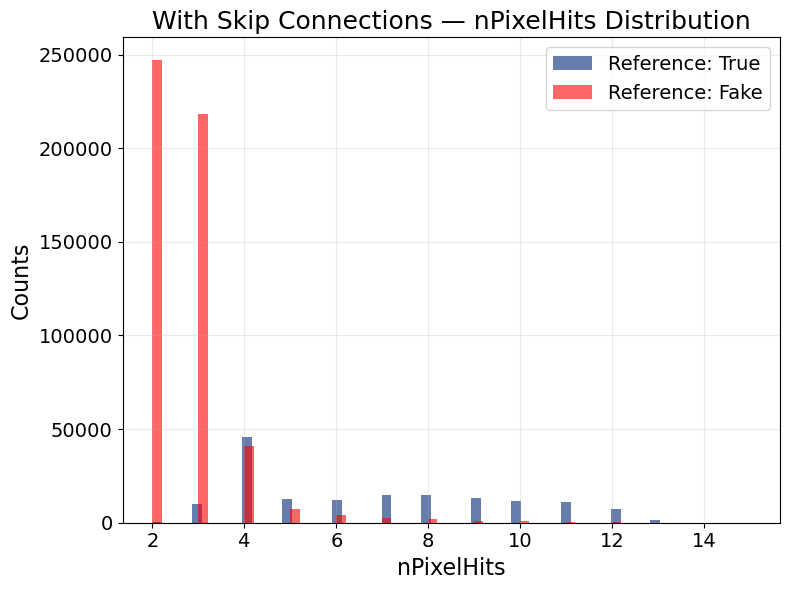

total true tracks:  155392
nPixelHits==2:  0.40156507413509057 %
nPixelHits==3:  29.620572487644154 %
nPixelHits==3 and ndof == 3:  2.330879324546952 %


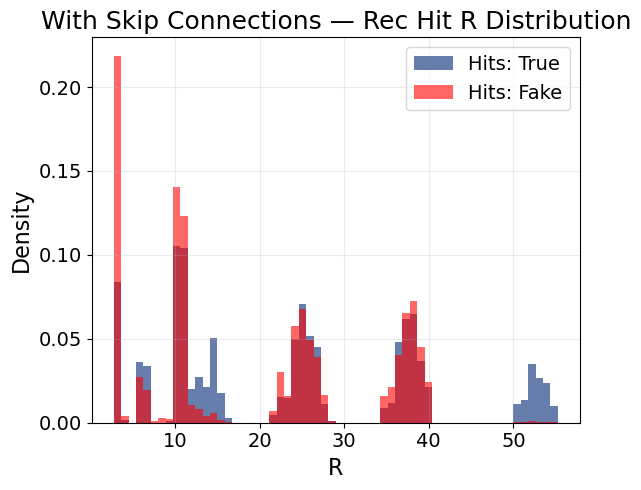

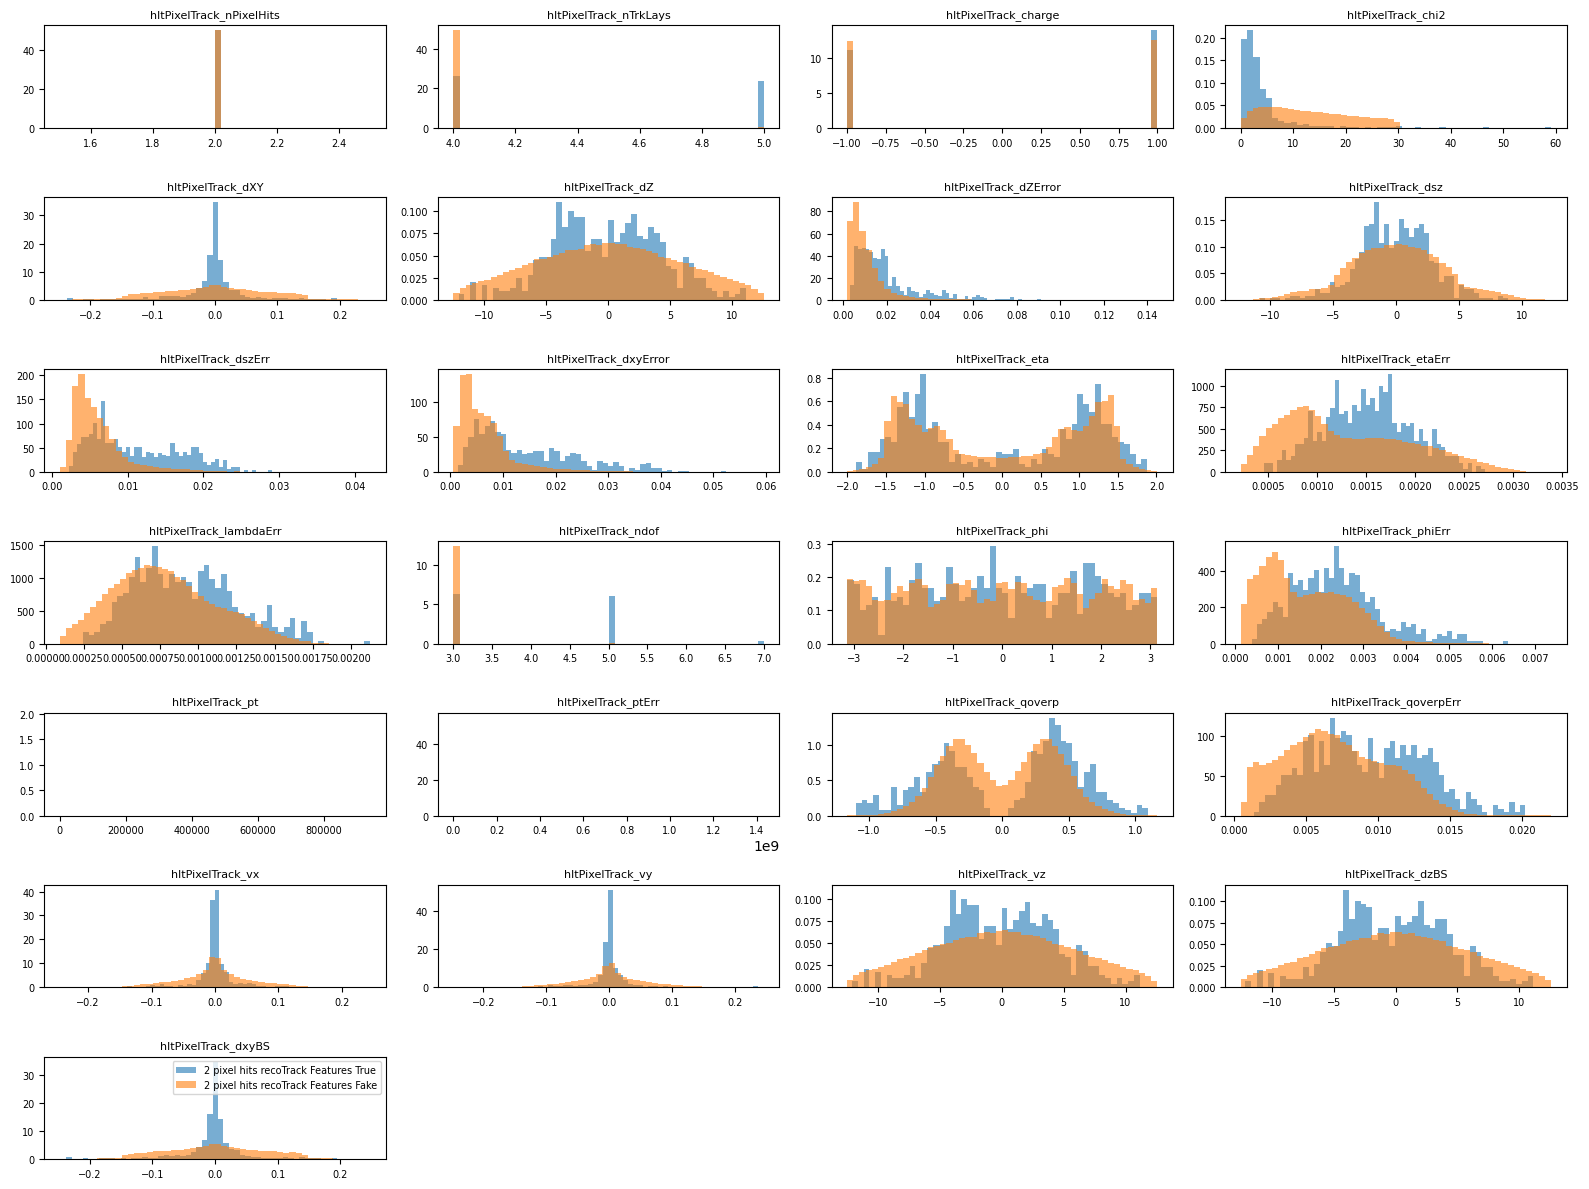

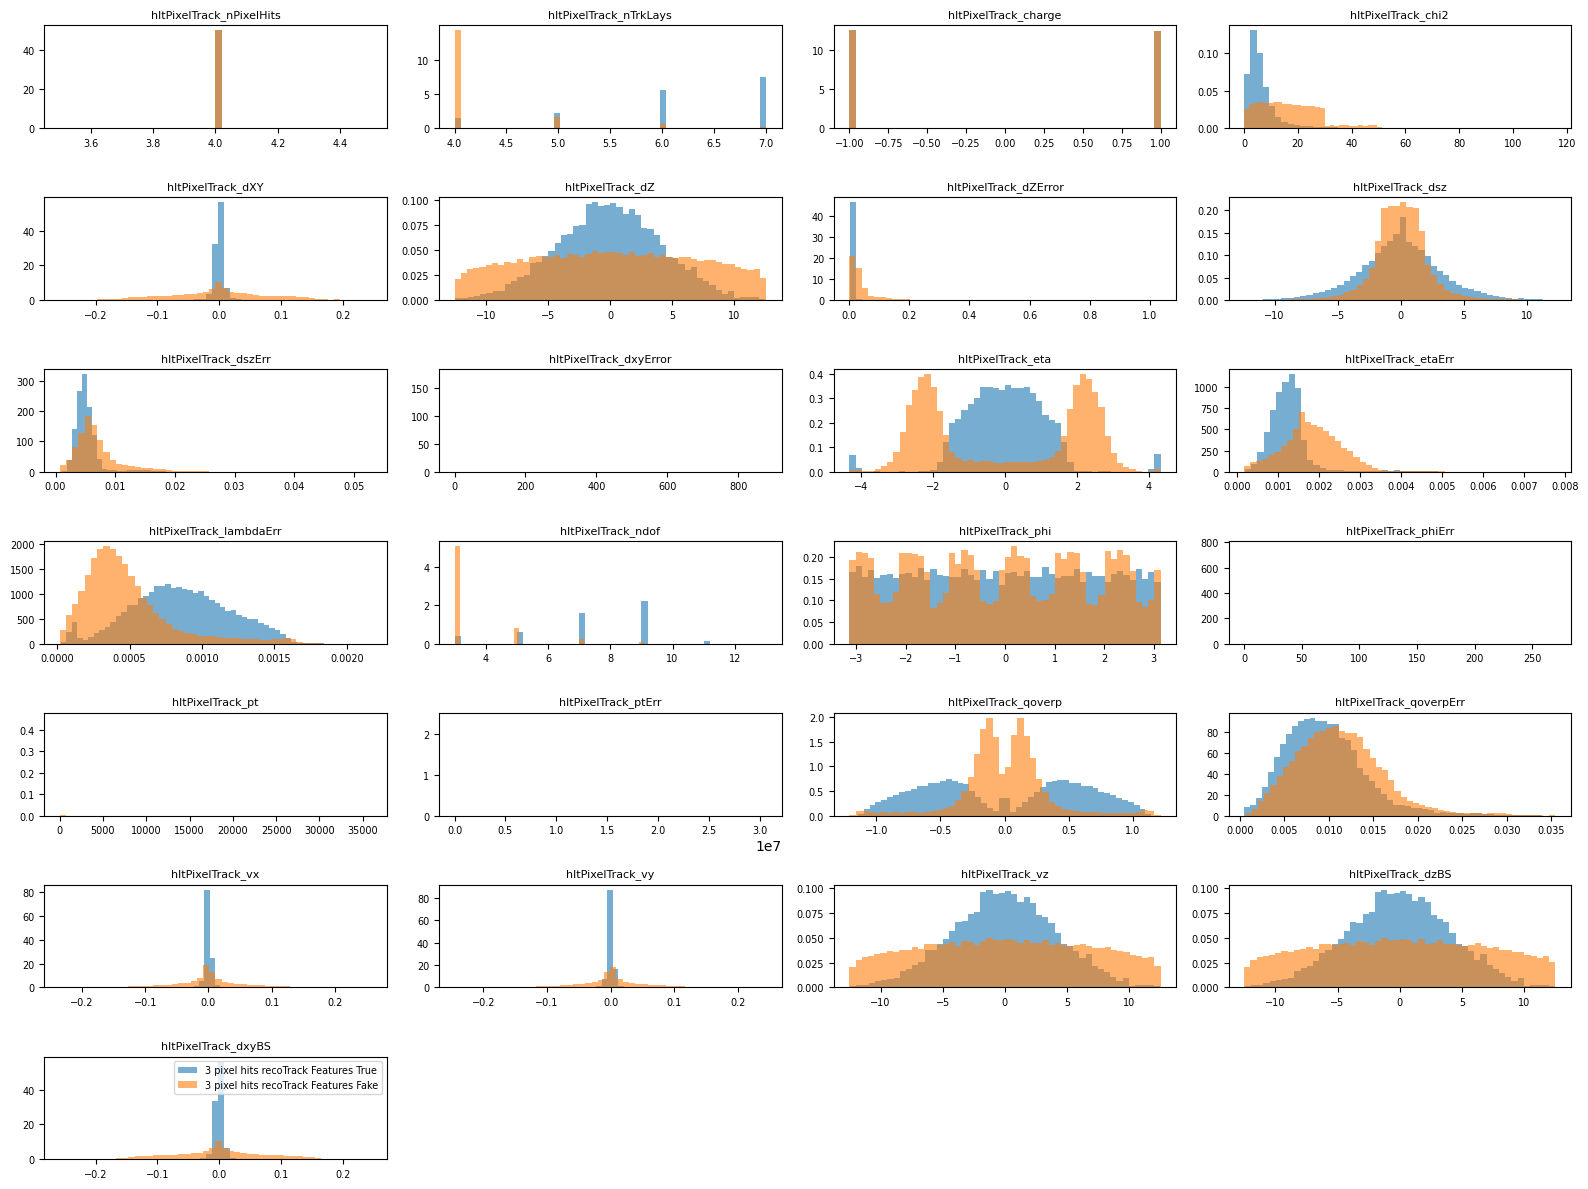

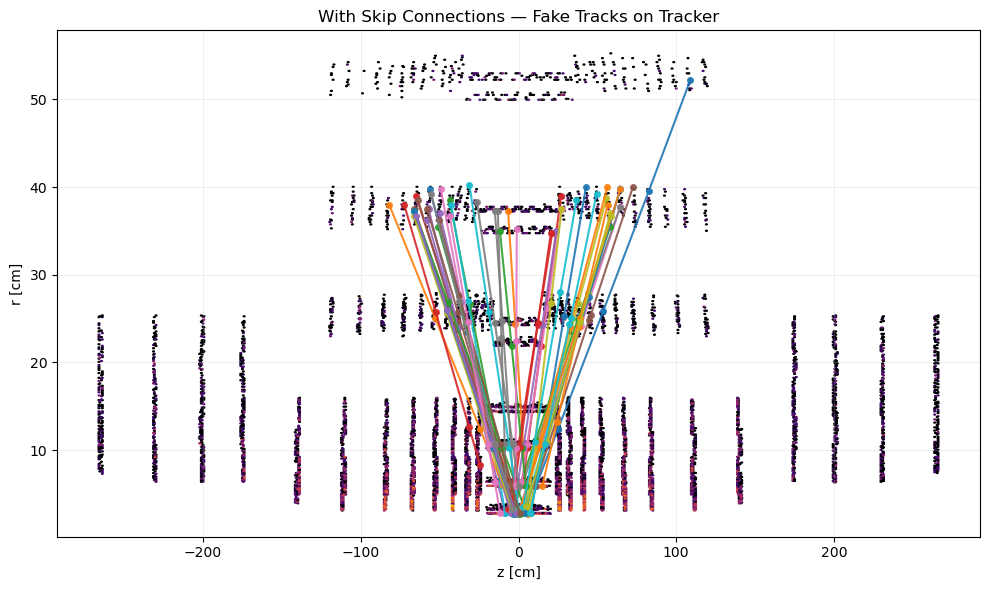

['Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']

-----------------------------------------------
-----------------------------------------------



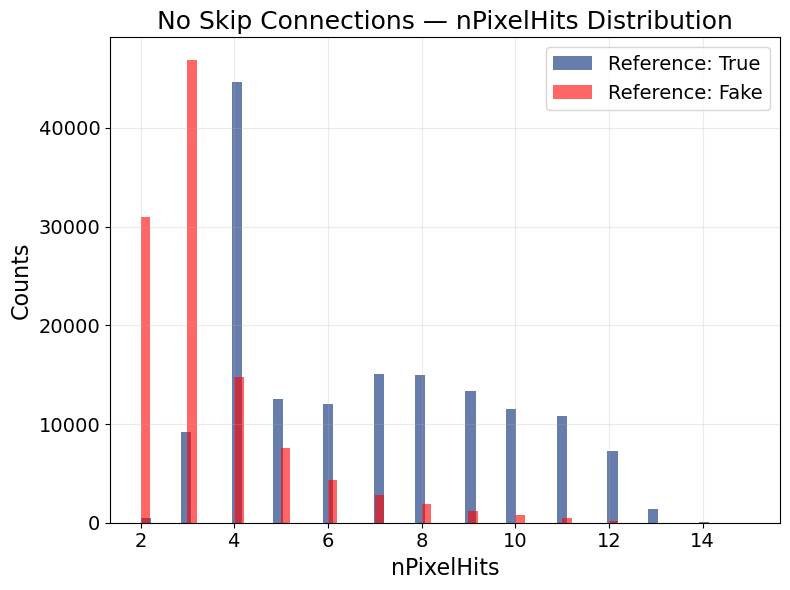

total true tracks:  153115
nPixelHits==2:  0.31871469157169446 %
nPixelHits==3:  29.191130849361592 %
nPixelHits==3 and ndof == 3:  1.4936485648042321 %


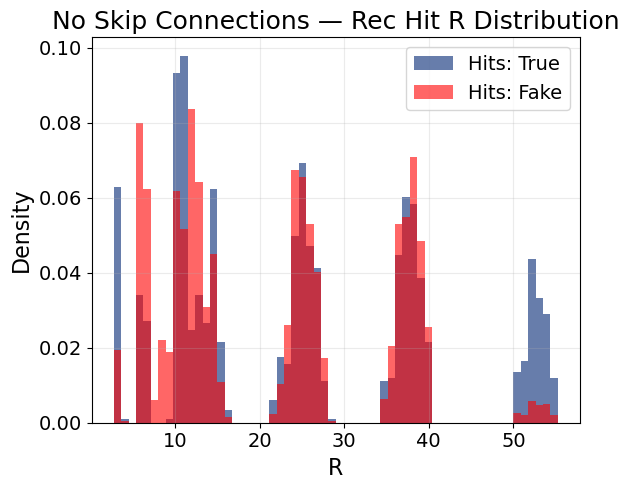

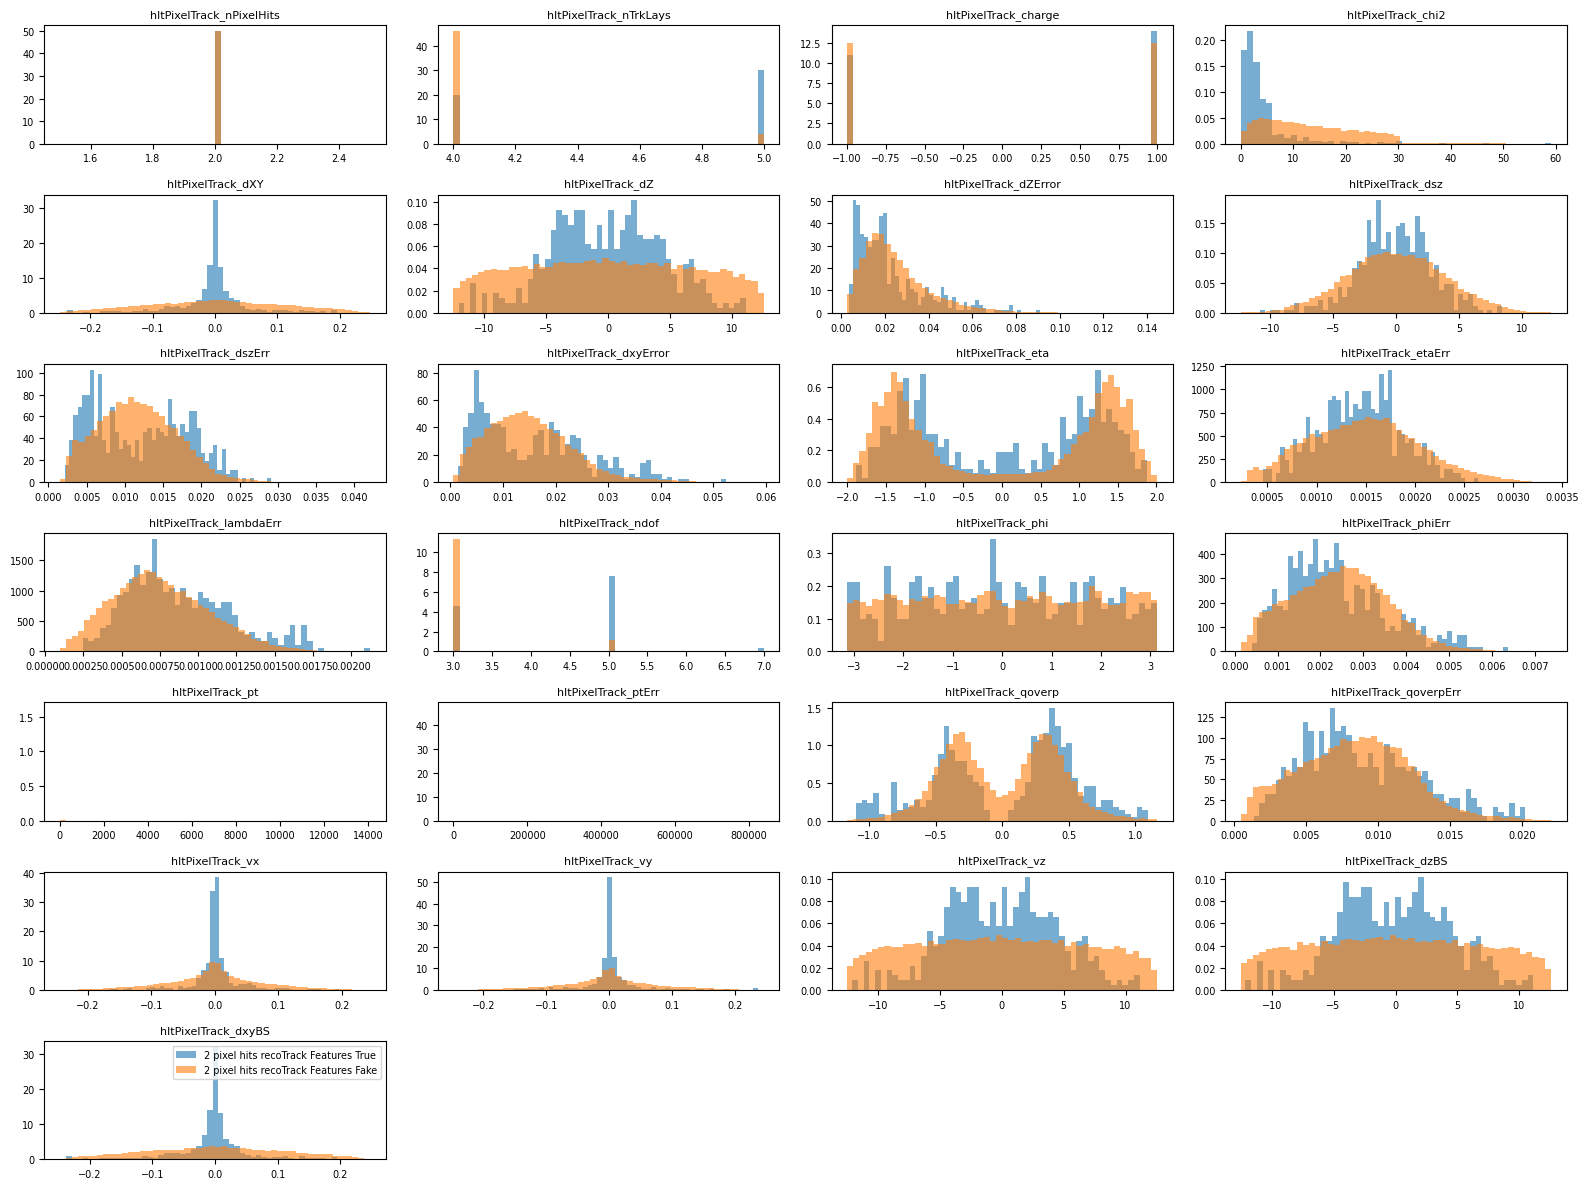

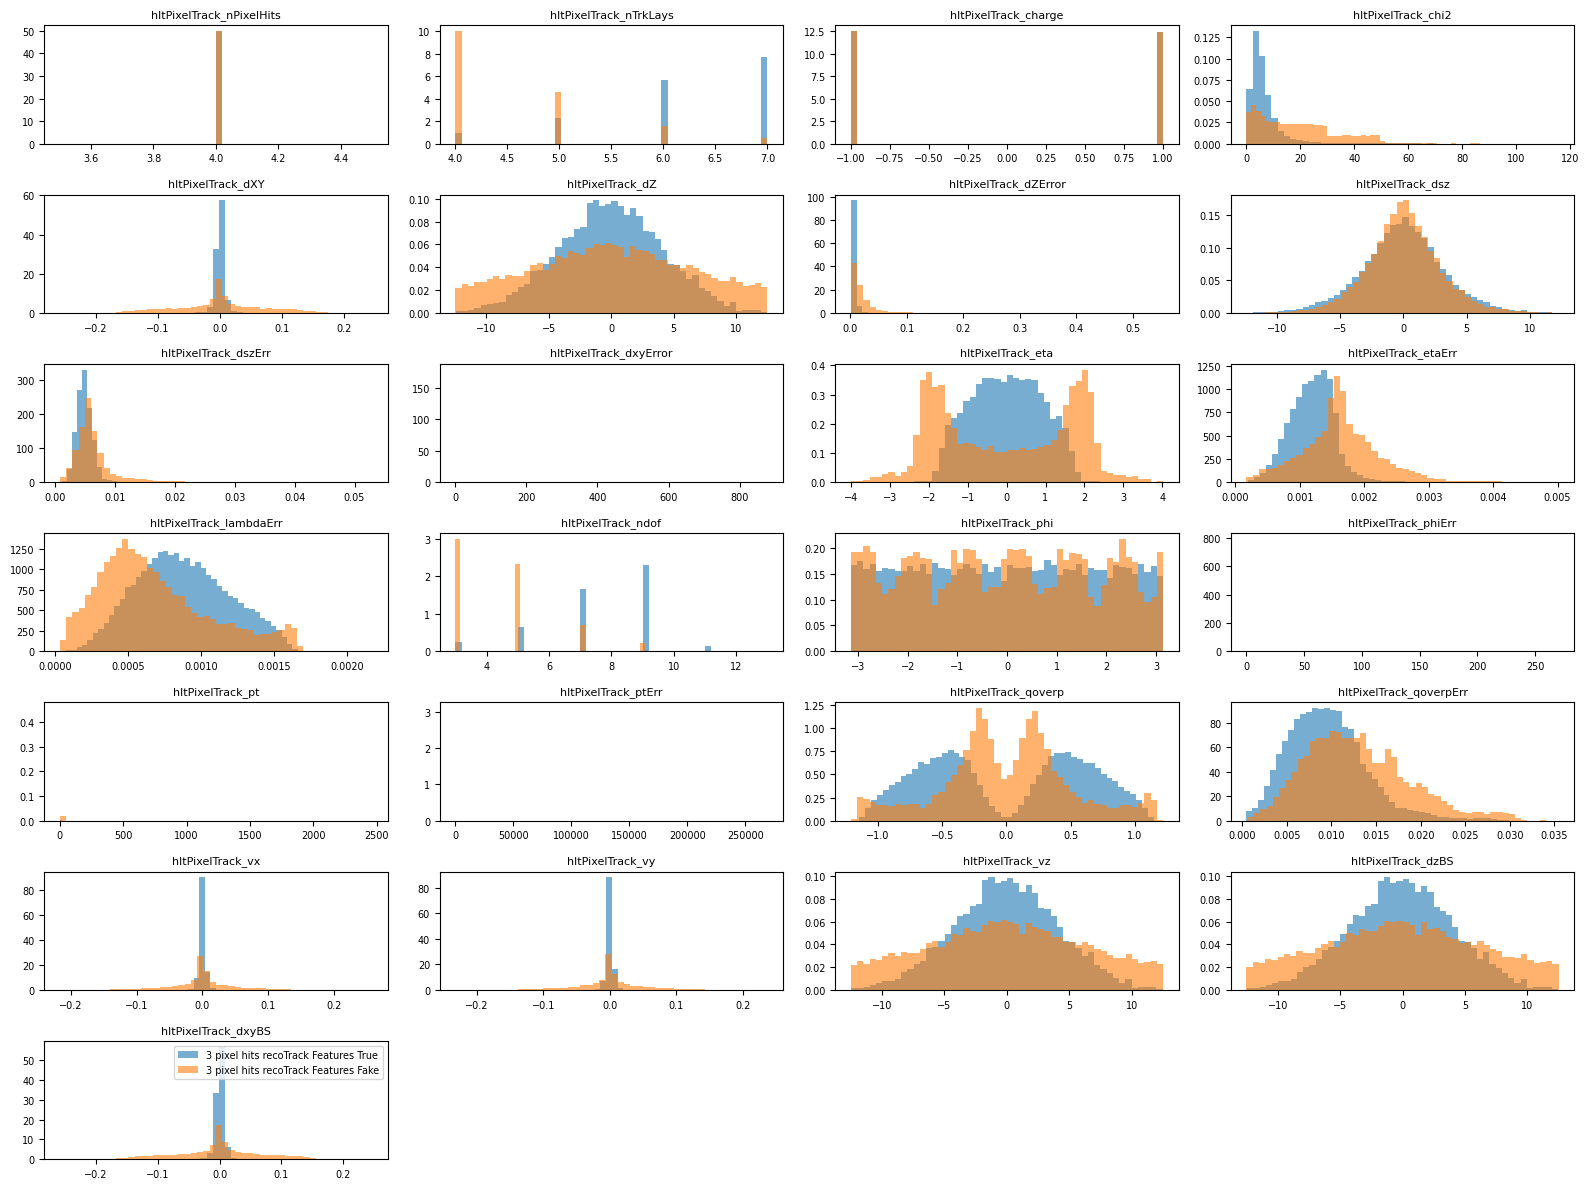

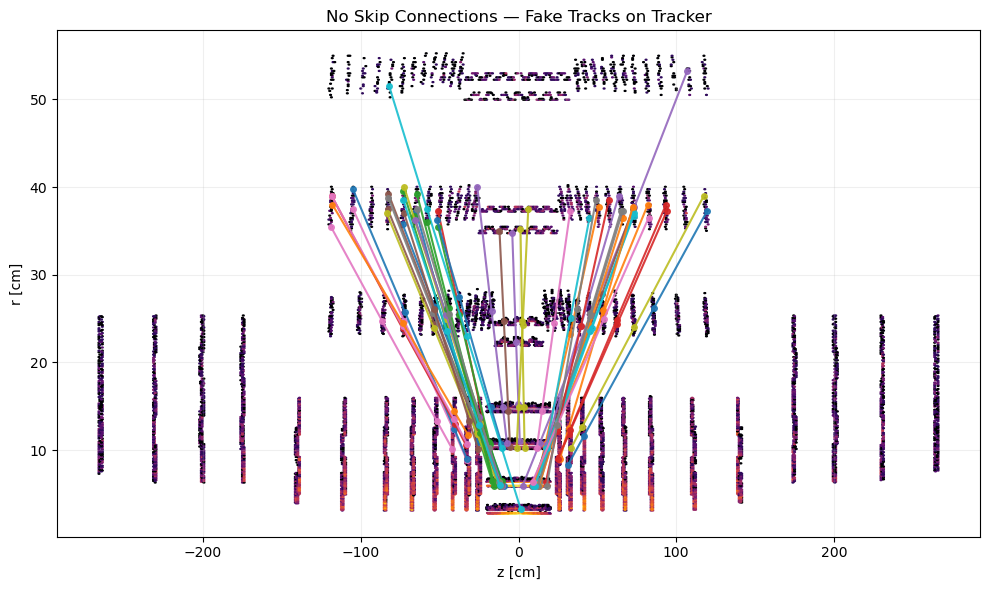

In [10]:
for CASE in CASES:
    TITLE_PREFIX = f"{CASE['label']} —"
    
    rng = np.random.default_rng(seed=CASE["seed"])
    
    INPUT_PATH = CASE["input_path"]
    
    file = uproot.open(INPUT_PATH)
    print(file.keys())
    
    print("\n-----------------------------------------------")
    print("-----------------------------------------------\n")
    
    events = file["Events"]
    
    data = events.arrays(library="ak")
    
    # ===============================
    #  Build recHit tensor
    # ===============================
    
    recHitFeaturesList = []
    for b in recHitBranches:
        arr = ak.to_numpy(ak.flatten(data[b])).reshape(-1, MAX_HITS)
        recHitFeaturesList.append(arr)
    
    recHitFeatures = np.stack(recHitFeaturesList, axis=2)
    
    mask = np.isnan(recHitFeatures[:, :, 0])
    recHitFeatures[mask] = 0.0
    isRecHit = ~mask
    
    # ===============================
    #  Build recoPixelTrack features
    # ===============================
    
    recoPixelTrackList = []
    for b in recoPixelTrackBranches:
        recoPixelTrackList.append(ak.to_numpy(ak.flatten(data[b])))
    
    recoPixelTrackFeatures = np.stack(recoPixelTrackList[2:], axis=1)
    recoPixelTrackLabels = np.array(recoPixelTrackList[0])
    recoPixelTrackIsHighPurity = np.array(recoPixelTrackList[1])
    
    recoPixelTrackFeatures_names = recoPixelTrackBranches[2:]
    
    
    #===============================
    # 1D feature plot
    #===============================
    
    fname = "hltPixelTrack_nPixelHits"
    i = recoPixelTrackFeatures_names.index(fname)
    HP_cmp = recoPixelTrackFeatures.copy()
    HP_cmp = HP_cmp[recoPixelTrackIsHighPurity.astype(bool),...]
    HP_recoPixelTrackLabels = recoPixelTrackLabels[recoPixelTrackIsHighPurity.astype(bool)]
    
    plot_single_feature(
        X_ref=recoPixelTrackFeatures,
        #X_ref = HP_cmp,
        feature_index=i,
        feature_name=fname,
        y=recoPixelTrackLabels,
        #y=HP_recoPixelTrackLabels,
        density=False,
        title=f"{TITLE_PREFIX} nPixelHits Distribution",
        xlabel="nPixelHits"
    )
    
    fname = "hltPixelTrackRecHits_globalR"
    i = recHitBranches.index(fname)
    
    npixel_hits = recoPixelTrackFeatures[:,0]
    ndof =  recoPixelTrackFeatures[:,13]
    mask_hits   = (npixel_hits==2)
    mask_3hits  = (npixel_hits==4)
    mask_ndof  = (ndof > 3)
    print('total true tracks: ', recoPixelTrackLabels.sum())
    print('nPixelHits==2: ', (mask_hits & recoPixelTrackLabels).sum()/recoPixelTrackLabels.sum()*100, '%')
    print('nPixelHits==3: ', (mask_3hits & recoPixelTrackLabels).sum()/recoPixelTrackLabels.sum()*100, '%')
    print('nPixelHits==3 and ndof == 3: ', (mask_3hits & recoPixelTrackLabels & ~mask_ndof).sum()/recoPixelTrackLabels.sum()*100, '%')

    recHitFeatures_flat = np.array(masked_flatten(recHitFeatures[mask_hits,:,:], isRecHit[mask_hits])).T
    y_hits = np.repeat(recoPixelTrackLabels[mask_hits], isRecHit[mask_hits].sum(axis=1))  # only if you want to compare by label
    
    plot_single_feature(
        X_ref=recHitFeatures_flat,
        feature_index=i,
        feature_name=fname,
        y=y_hits,
        density=True,
        figsize=(6, 5),
         labels=("Hits", ""),
        title=f"{TITLE_PREFIX} Rec Hit R Distribution",
        xlabel="R"
    )

    #===============================
    # General feature plot
    #===============================
    
    plot_feature_distributions(
        X_ref=recoPixelTrackFeatures[mask_hits],
        feature_names=recoPixelTrackFeatures_names,
        y=recoPixelTrackLabels[mask_hits],
        labels=("2 pixel hits recoTrack Features",)
    )

    plot_feature_distributions(
        X_ref=recoPixelTrackFeatures[mask_3hits],
        feature_names=recoPixelTrackFeatures_names,
        y=recoPixelTrackLabels[mask_3hits],
        labels=("3 pixel hits recoTrack Features",)
    )
    
    #===============================
    # Tracker visualization
    #===============================
    
    max_tracks = 10000
    r_idx = recHitBranches.index("hltPixelTrackRecHits_globalR")
    z_idx = recHitBranches.index("hltPixelTrackRecHits_globalZ")
    n_tracks_to_plot = 50
    
    # Shuffle
    
    N = recHitFeatures.shape[0]
    perm = rng.permutation(N)
    
    recHitFeatures_shuf = recHitFeatures[perm]
    isRecHit_shuf = isRecHit[perm]
    labels_shuf = recoPixelTrackLabels[perm]
    
    # Skim
    
    labels_skim = labels_shuf[:max_tracks].astype(bool)
    recHit_skim = recHitFeatures_shuf[:max_tracks]
    isRecHit_skim = isRecHit_shuf[:max_tracks]
    
    true_hits = recHit_skim[labels_skim]
    isRecHit_true = isRecHit_skim[labels_skim]
    
    r_hits = true_hits[..., r_idx][isRecHit_true]
    z_hits = true_hits[..., z_idx][isRecHit_true]
    
    mask_fake = (recoPixelTrackLabels == 0)
    mask_hits = (recoPixelTrackFeatures[:, 0] == 2)
    
    hits_fake = recHitFeatures[mask_fake & mask_hits]
    
    if hits_fake.shape[0] < n_tracks_to_plot:
        n_tracks_to_plot = hits_fake.shape[0]
        
    track_indices = rng.choice(hits_fake.shape[0], size=n_tracks_to_plot, replace=False)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    hb = ax.hexbin(z_hits, r_hits, gridsize=500, bins="log", cmap="inferno", mincnt=1)
    
    for idx in track_indices:
        track = hits_fake[idx]
        z_track = track[..., z_idx]
        r_track = track[..., r_idx]
        valid = (z_track != 0) & (r_track != 0)
        ax.plot(z_track[valid], r_track[valid], "-o", lw=1.5, ms=4, alpha=0.9)
        
    ax.set_xlabel("z [cm]")
    ax.set_ylabel("r [cm]")
    ax.set_title(f"{TITLE_PREFIX} Fake Tracks on Tracker")
    ax.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

In [ ]:
import re
import matplotlib.pyplot as plt

logfile = "/eos/user/e/ecoradin/CMSSW_16_0_0_pre3/src/TrackCutLog"

pattern = re.compile(r"nPixelHits:\s*(\d+)")

values = []

with open(logfile, "r") as f:
    for line in f:
        match = pattern.search(line)
        if match:
            values.append(int(match.group(1)))

if not values:
    raise RuntimeError("No nPixelHits entries found")

# Define explicit bins for integers 0–15
bins = [i - 0.5 for i in range(0, 17)]  # edges from -0.5 to 15.5
print('Total tracks: ', len(values))
plt.figure()
plt.hist(
    values,
    bins=bins,
    density=False,
    rwidth=0.8,        # space between bars
    edgecolor="black" # clear visual separation
)

plt.xticks(range(0, 16))
plt.xlabel("Number of valid pixel hits")
plt.ylabel("Entries")
plt.title("nPixelHits distribution (0–15)")
plt.grid(axis="y", alpha=0.5)

plt.show()

In [ ]:
import re
import matplotlib.pyplot as plt

logfile = "/eos/user/e/ecoradin/CMSSW_16_0_0_pre3/src/TrackCutLogBeforeCut"

pattern = re.compile(r"nPixelHits:\s*(\d+)")

values = []

with open(logfile, "r") as f:
    for line in f:
        match = pattern.search(line)
        if match:
            values.append(int(match.group(1)))

if not values:
    raise RuntimeError("No nPixelHits entries found")
print('Total tracks: ', len(values))
# Define explicit bins for integers 0–15
bins = [i - 0.5 for i in range(0, 17)]  # edges from -0.5 to 15.5

plt.figure()
plt.hist(
    values,
    bins=bins,
    density=False,
    rwidth=0.8,        # space between bars
    edgecolor="black" # clear visual separation
)

plt.xticks(range(0, 16))
plt.xlabel("Number of valid pixel hits")
plt.ylabel("Entries")
plt.title("nPixelHits distribution (0–15)")
plt.grid(axis="y", alpha=0.5)

plt.show()